## Classroom exercise: the biggest earthquake in the UK this century

### The Problem

GeoJSON is a JSON-based file format for sharing geographic data. One example dataset is the USGS earthquake data:

In [3]:
import requests
quakes = requests.get("http://earthquake.usgs.gov/fdsnws/event/1/query.geojson",
                      params={
                          'starttime': "2000-01-01",
                          "maxlatitude": "58.723",
                          "minlatitude": "50.008",
                          "maxlongitude": "1.67",
                          "minlongitude": "-9.756",
                          "minmagnitude": "1",
                          "endtime": "2018-10-11",
                          "orderby": "time-asc"}
                      )

In [4]:
quakes.text[0:100]

'{"type":"FeatureCollection","metadata":{"generated":1571927785000,"url":"https://earthquake.usgs.gov'

Your exercise: determine the location of the largest magnitude earthquake in the UK this century.

You'll need to:
* Get the text of the web result
* Parse the data as JSON
* Understand how the data is structured into dictionaries and lists
   * Where is the magnitude?
   * Where is the place description or coordinates?
* Program a search through all the quakes to find the biggest quake
* Find the place of the biggest quake
* Form a URL for an online map service at that latitude and longitude: look back at the introductory example
* Display that image

In [5]:
# Parse JSON file
import json 
quakes_json = json.loads(quakes.text)
print(quakes_json.keys()) # get root keys for json 
print(len(quakes_json['features']), 'quakes\n') # 1 feature = 1 quake
print('Structure of each feature:')
quakes_json['features'][0]

dict_keys(['type', 'metadata', 'features', 'bbox'])
120 quakes

Structure of each feature:


{'type': 'Feature',
 'properties': {'mag': 2.6,
  'place': 'England, United Kingdom',
  'time': 956553055700,
  'updated': 1415322596133,
  'tz': None,
  'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/usp0009rst',
  'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp0009rst&format=geojson',
  'felt': None,
  'cdi': None,
  'mmi': None,
  'alert': None,
  'status': 'reviewed',
  'tsunami': 0,
  'sig': 104,
  'net': 'us',
  'code': 'p0009rst',
  'ids': ',usp0009rst,',
  'sources': ',us,',
  'types': ',impact-text,origin,phase-data,',
  'nst': None,
  'dmin': None,
  'rms': None,
  'gap': None,
  'magType': 'ml',
  'type': 'earthquake',
  'title': 'M 2.6 - England, United Kingdom'},
 'geometry': {'type': 'Point', 'coordinates': [-2.81, 54.77, 14]},
 'id': 'usp0009rst'}

In [6]:
# Iterate through the features list
magnitude_dict = {'coord':[],'place':[],'mag':[]}
for i in range(len(quakes_json['features'])):
    magnitude_dict['mag'].append(quakes_json['features'][i]['properties']['mag'])
    magnitude_dict['place'].append(quakes_json['features'][i]['properties']['place'])
    magnitude_dict['coord'].append(quakes_json['features'][i]['geometry']['coordinates'])           
magnitude_dict


{'coord': [[-2.81, 54.77, 14],
  [-1.61, 52.28, 13.1],
  [1.564, 53.236, 10],
  [0.872, 58.097, 10],
  [-1.845, 51.432, 10],
  [-3.639, 55.102, 12.3],
  [-4.684, 50.995, 28.7],
  [1.144, 51.76, 10],
  [1.094, 51.332, 10],
  [-3.205, 51.552, 10],
  [-3.25, 51.7, 7.9],
  [-0.856, 52.846, 11.6],
  [-3.14, 51.63, 10],
  [1.288, 53.168, 10],
  [-3.255, 51.7, 8.3],
  [-3.081, 51.567, 14.3],
  [-0.009, 50.048, 4],
  [-5.749, 56.596, 7.6],
  [-3.588, 51.713, 1.5],
  [-2.15, 52.52, 9.4],
  [-2.136, 52.522, 9.3],
  [-2.138, 52.521, 7.9],
  [-2, 53.475, 5],
  [-2.219, 53.478, 5],
  [-2.219, 53.463, 5],
  [-2.146, 53.473, 4.2],
  [-2.157, 53.477, 5],
  [-2.179, 53.485, 3.7],
  [-2.197, 53.482, 5],
  [-2.204, 53.481, 5],
  [-2.213, 53.488, 5],
  [-2.188, 53.477, 5],
  [-2.198, 53.481, 5],
  [1.582, 51.055, 10],
  [-4.416, 56.169, 5],
  [-4.439, 56.181, 5.4],
  [-4.427, 56.167, 4.3],
  [-1.013, 53.481, 13.2],
  [-2.98, 51.089, 6.5],
  [-2.98, 51.089, 6.5],
  [-2.98, 51.089, 6.5],
  [-1.999, 53.566, 

In [7]:
# Find max magnitude quake
import pandas as pd
df = pd.DataFrame.from_dict(magnitude_dict)
df = df.sort_values('mag', ascending=True)
# locate the rows with max magnitude
df_max = df.loc[df['mag'] == max(df['mag'])]
df_max

,coord,place,mag
19,"[-2.15, 52.52, 9.4]","England, United Kingdom",4.8
81,"[-0.332, 53.403, 18.4]","England, United Kingdom",4.8


In [8]:
# Open location of the largest quake in static map
import requests

def request_map_at(lat, long, satellite=True,
                   zoom=10, size=(400, 400)):
    base = "https://static-maps.yandex.ru/1.x/?"

    params = dict(
        z=zoom,
        size="{},{}".format(size[0], size[1]),
        ll="{},{}".format(long, lat),
        l="sat" if satellite else "map",
        lang="en_US"
    )

    return requests.get(base, params=params)   

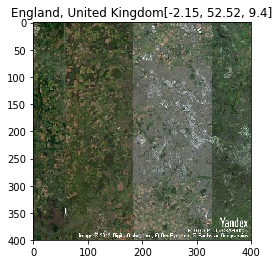

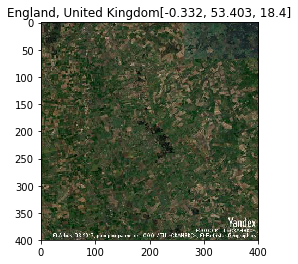

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import imageio

# iterate through each max quake and get lat and long, and retrieve satellite image
map_png=[]
for index, row in df_max.iterrows():
    long = row['coord'][0]
    lat = row['coord'][1]
    map_uri = request_map_at(lat, long)
    map_bytes = map_uri.content
    # Convert image from bytes to image and display it
    im = imageio.imread(map_bytes)
    plt.figure()
    plt.imshow(im)
    plt.title(row['place']+str(row['coord']))